In [2]:
import VMBQC_functions
from VMBQC_functions import *

In [3]:
torch.cuda.is_available()

True

In [1]:
# Hyperparameters

# Pennylane devices have inbuild command names "shots" which is number of samples for a specific circuit architecture
N=10 # number of "shots"

samples=20000 # Total number of samples from MBQC-CQCA (includes the "shots" for each circuit with different byproducts)

runs=int(samples/N) # Number of times our model should run (at each of this "runs", the specific pennylane circuit provides N=10 "shots" / samples)

qubits=8
depth=7
layers=depth

In [5]:
# definign inverse of our sigmoid function

def inv_sigmoid(x):
    return np.log(x/(1-x))

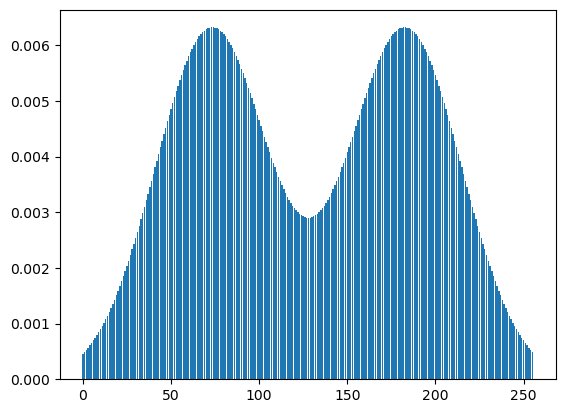

In [34]:
# Defining the mixed gaussian function and plotting with specific mean and varience

def double_gaussian_pdf(num_bit, mu1,mu2, sigma):
    '''get gaussian distribution function'''
    x = np.arange(2**num_bit) # samples
    pl = 1. / np.sqrt(2 * np.pi * sigma**2) * \
        (np.exp(-(x - mu1)**2 / (2. * sigma**2))+np.exp(-(x - mu2)**2 / (2. * sigma**2)))
    return pl/pl.sum()


pg = double_gaussian_pdf(qubits, 2*(2**qubits)/7, 5*(2**qubits)/7, (2**qubits)/8)
plt.bar(range(2 ** qubits),pg)
plt.show()

In [35]:
# Here we build the fully corrected CQCA circuit which gives a pure state. 

dev = qml.device("default.qubit", wires=qubits,shots=samples)

@qml.qnode(dev)
def eqv_circ_st(params):  
    
    p=params[:int(len(params)/2)] # probabilities
    
    t=params[len(p):] # thetas
    
    # Design of the fully corrected CQCA
    
    [qml.Hadamard(wires=q) for q in range(qubits)]
    for l in range(depth): 
        
        for q in range(qubits):
            if q<qubits-1:
                qml.CZ(wires=[q,q+1])
        qml.CZ(wires=[0,qubits-1])    
        for q in range(qubits):
            qml.RZ(t[qubits*l+q],wires=q)
            qml.Hadamard(wires=q)
       
            # qml.BitFlip((1-sigmoid(p[qubits*l+q]))/2,wires=q)
    
    return qml.sample()#qml.probs(wires=range(qubits))

In [36]:
# Similar to the above cell we initialize our main model \tilde{\epsilon}_c with the hyperparameters
model=VMBQC(qubits,layers,N)

In [37]:
# def sample_circ(par):
    
#     binary_array = np.array(eqv_circ_st(par))
#     #print(binary_array)
#     powers_of_two = 2 ** np.arange(binary_array.shape[1])[::-1]
#     decimal_array = np.sum(binary_array * powers_of_two, axis=1)
#     decimal_list = decimal_array.tolist()
    
#     return decimal_list


#####   For model 2

'''
Activate the below part when model \tilde{\epsilon}_c is in action and comment the part above to avoid any overlap and do the reverse if needed.
'''
# function to get a single (1) (or, N = shots) number of data sample(s) from a single run of CQCA with given correction probabilities (p)
def get_samples_jl(runs, params):
    arr=[]
    p=params[:int(len(params)/2)] 
    t=params[len(p):] 
    
    arr.append(model.corrected_machine_f2(p,t))
    return np.concatenate(arr)


# function to get m (e.g. "runs=20000/10=2000") number of data samples from our model
def sample_circ(par):
    
    # usinf joblib to parallalize the process of generating sufficient samples
    results = Parallel(n_jobs = 20)(delayed(get_samples_jl)(r, par) for r in range(runs))
    s_a=list(itertools.chain.from_iterable(results))
    binary_array = np.array(s_a)
    #print(binary_array)
    powers_of_two = 2 ** np.arange(binary_array.shape[1])[::-1]
    decimal_array = np.sum(binary_array * powers_of_two, axis=1)
    decimal_list = decimal_array.tolist()
    
    return decimal_list
    

In [38]:
# sampling from target distribution e.g. mixed gaussian
def sample_target_function():
    x=range(2**qubits)
    ret = np.random.choice(x,samples,p=pg)
    return ret.copy()

In [39]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [40]:
# kernel function to calculate distance between two sample data points

def kernel_exp_torch(s1,s2):
    s1t = torch.tensor(s1, dtype = torch.float64).to(DEVICE)
    s2t = torch.tensor(s2, dtype = torch.float64).to(DEVICE)
    d1 = s1t.size(-1)
    d2 = s2t.size(-1)
    s1t = s1t.reshape([1,-1,1])
    s2t = s2t.reshape([1,-1,1])
    
    diffsquared = (torch.cdist(s1t,s2t,p=2.0).to(DEVICE))**2

    sigma_list=[0.5,4]
    exp = 0.0
    for sigma in sigma_list:
        expMatrix = torch.exp(diffsquared/(-2.0*sigma)).to(DEVICE)
        expMatrix = expMatrix/(len(sigma_list)*d1*d2)
        exp = exp + torch.sum(expMatrix).to(DEVICE)
        
    return exp

In [41]:
def mmd_loss(params):
    
    s2=sample_target_function()
    s1=sample_circ(params)
    res=kernel_exp_torch(s1,s1)-2*kernel_exp_torch(s1,s2)+kernel_exp_torch(s2,s2)
    return res.detach().cpu().numpy()


In [42]:
# Gradient for correction probabilities stated in eq. 17 of: https://arxiv.org/pdf/2310.13524.pdf

def mmd_grad_p_new(params):
    p=params[:qubits*depth]
    thetas=params[len(p):]
    grad = torch.zeros(len(p)).to(DEVICE)
    
    
    
    sample_targ=sample_target_function()
    
    for i in range(len(p)):
        
        sample_y = sample_circ(params) ###############  eqv_circ_st(params)
        
        a=p[i].copy()
        inner_derivative = (sigmoid(torch.tensor(a))**2)*torch.exp(-torch.tensor(a))
        
        p[i]=torch.tensor(100.0).numpy()
        
        sample_x_1 = sample_circ(params) ###############  eqv_circ_st(params)
       
        
        p[i]=torch.tensor(-100.0).numpy()
        
        sample_x_0 = sample_circ(params) ###############  eqv_circ_st(params)
        
        
        grad[i]=2*(kernel_exp_torch(sample_y,sample_x_1)-kernel_exp_torch(sample_y,sample_x_0)) - 2*(kernel_exp_torch(sample_targ,sample_x_1)-kernel_exp_torch(sample_targ,sample_x_0))
        grad[i]= grad[i]*inner_derivative
        p[i]=a
        #if i == 0:
        #    print(params[:int(len(params)/2)])

        
    return grad
    
    
    
# Gradient for variational parameters \thetas stated in eq. 16 of: https://arxiv.org/pdf/2310.13524.pdf
    
def mmd_grad_theta(params):
    p=params[:qubits*depth]
    thetas=params[len(p):]
    prob = sample_circ(params)
    grad = torch.zeros(len(thetas)).to(DEVICE)
    
    for i in range(len(thetas)):
        # pi/2 phase
        thetas[i] += np.pi/2.
        prob_pos = sample_circ(params) # p_{theta}^{+}
        # -pi/2 phase
        thetas[i] -= np.pi
        prob_neg = sample_circ(params) # p_{theta}^{-}
        
        t1=kernel_exp_torch(prob, prob_pos)
        
        t2=kernel_exp_torch(prob, prob_neg)

        t3=kernel_exp_torch(sample_target_function(), prob_pos)
        
        t4=kernel_exp_torch(sample_target_function(), prob_neg)

        
        grad_pos = t1 - t2
        grad_neg = t3 - t4
        grad[i] = (grad_pos - grad_neg).detach().cpu()
        
        thetas[i] += np.pi/2.0 #reset to original value
        
    return grad


# combined gradient of both sets of parameters

def mmd_grad(params):
    #probs=params[:int(len(params)/2)]
    #thetas=params[len(probs):]
    grad=torch.cat((mmd_grad_p_new(params),mmd_grad_theta(params)))
    return grad

In [43]:
'''
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(obj.shape, type(obj), obj.size(), obj.device)
    except:
        pass
'''

"\nimport torch\nimport gc\nfor obj in gc.get_objects():\n    try:\n        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):\n            print(obj.shape, type(obj), obj.size(), obj.device)\n    except:\n        pass\n"

In [44]:
#torch.cuda.empty_cache()

In [45]:
#import gc

#gc.collect()
#torch.cuda.empty_cache()


In [46]:
# algorithm for gradient descent copied from : https://docs.pennylane.ai/en/stable/code/api/pennylane.GradientDescentOptimizer.html

# We rewrote the algorithm with our approximate gradient calculated from samples instead of using the in-built exact gradient 

class GradientDescentOptimizer_mmd_2:  
    def __init__(self, stepsize): # if some value is given here itself then it will become a by default value
        self.stepsize = stepsize

    def step_and_cost(self, objective_fn, *args, grad_fn=None, **kwargs):
        
        g, forward = self.compute_grad(objective_fn, args, kwargs, grad_fn=grad_fn)
        new_args = self.apply_grad(g, args)

        if forward is None:
            forward = objective_fn(*args, **kwargs)

        # unwrap from list if one argument, cleaner return
        if len(new_args) == 1:
            return new_args[0], forward
        return new_args, forward


    def step(self, objective_fn, *args, train, grad_fn=None, **kwargs):
        
        p_len=int(len(args[0])/2)
        if train=='p':
            arg1=args[0][:int(len(args[0])/2)]
        else:
            arg1=args[0][int(len(args[0])/2):]
        
        g= self.compute_grad(objective_fn, args, kwargs, grad_fn=grad_fn)
        new_args = self.apply_grad(g, arg1,args,train)

        # unwrap from list if one argument, cleaner return
        if len(new_args) == 1:
            return new_args[0]

        return new_args

    @staticmethod
    def compute_grad(objective_fn, args, kwargs, grad_fn=None):
       
        
        grad = mmd_grad(*args).detach().cpu().numpy()
        

        num_trainable_args = sum(getattr(arg, "requires_grad", False) for arg in args)
        grad = (grad,) if num_trainable_args == 1 else grad
        #print('grads--',grad[0])
        return grad


    def apply_grad(self, grad, arg1,args,train):
        
        #print('arg1--',arg1)#################
        args_new = list(arg1)
        
        if train=='p':

            trained_index = 0
            for index, arg in enumerate(arg1):

                if getattr(arg, "requires_grad", False):
                    args_new[index] = arg - self.stepsize * grad[0][trained_index]

                    trained_index += 1
        else:
            trained_index = p_len ########## need to be generalized
            for index, arg in enumerate(arg1):
                if getattr(arg, "requires_grad", False):
                    args_new[index] = arg - self.stepsize * grad[0][trained_index]

                    trained_index += 1
            
        
        #print('new args-->',args_new[0])#############
        
        if train=='p':
            return np.concatenate([args_new,args[0][len(args_new):]])
        else:
            return np.concatenate([args[0][:len(args_new)],args_new]) # here we can do this only because the they have same size
        

In [47]:
# We use parts the above above algorithm to finally use the Adagrad optimization algorithm below to update our tunable parameters

from pennylane.numpy import sqrt
class AdagradOptimizer_mmd_2(GradientDescentOptimizer_mmd_2):
    

    def __init__(self, stepsize=0.01, eps=1e-8):
        super().__init__(stepsize)
        self.eps = eps
        self.accumulation = None

    def apply_grad(self, grad, arg1, args, train):
        
        p_len=int(len(args[0])/2)
        args_new = list(arg1)

        if self.accumulation is None:
            self.accumulation = [0.0] * len(arg1)
            
        if train=='p':

            trained_index = 0
            for index, arg in enumerate(arg1):
                if getattr(arg, "requires_grad", False):
                    

                    self._update_accumulation(index, grad[0][trained_index])

                    coeff = self.stepsize / sqrt(self.accumulation[index] + self.eps)
                    args_new[index] = arg - coeff * grad[0][trained_index]

                    trained_index += 1
                    
        else:
            
            trained_index = p_len # need to be generalized
            
            for index, arg in enumerate(arg1):
                if getattr(arg, "requires_grad", False):
                    

                    self._update_accumulation(index, grad[0][trained_index])

                    coeff = self.stepsize / sqrt(self.accumulation[index] + self.eps)
                    args_new[index] = arg - coeff * grad[0][trained_index]

                    trained_index += 1
            
            

        if train=='p':
            return np.concatenate([args_new,args[0][len(args_new):]])
        else:
            return np.concatenate([args[0][:len(args_new)],args_new])


    def _update_accumulation(self, index, grad):
        
        self.accumulation[index] = self.accumulation[index] + grad**2

    def reset(self):
        
        self.accumulation = None

In [48]:
def cost(par):

    c=mmd_loss(par) 
    return c

In [76]:
# params_arr2=np.loadtxt('target learned by Cf params 1.txt')
# cost_arr2=np.loadtxt('target learned by Cf cost 1.txt')

In [77]:
# p_test=params_arr2[-1]

In [78]:
# s=time.time()
# f_s_t=plt.hist(sample_circ(p_test),bins=2**qubits)
# e=time.time()
# print(e-s,'sec')

In [79]:
# pg2=f_s_t[0]/(samples)

In [80]:
# np.sum(pg2)

In [81]:
# plt.plot(range(2 ** qubits),pg,color='black')
# plt.bar(range(2 ** qubits),pg2,color='dodgerblue')
# plt.xlim(0,255)
# plt.show()

In [2]:
# p2=np.random.uniform((1-2/(qubits*depth)),1,qubits*depth)# probabilities with which we are going to 
# t2=np.random.rand(qubits*depth)
# init_p=np.concatenate([inv_sigmoid(p2),t2], requires_grad=True)
# cost(init_p)

In [49]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [55]:
cost_arr=[]
params_arr=[]
# params_arr2=np.loadtxt('target learned 7 layers by C params.txt')

In [ ]:
runs_2=1
iterations=199  # next time if run the same experiment for more agents then iterations=199

for r in range(runs_2):
    opt1 = AdagradOptimizer_mmd_2(stepsize=0.4)
    opt2 = AdagradOptimizer_mmd_2(stepsize=0.1)
    p2=np.random.uniform(.9,1,qubits*depth)# probabilities with which we are going to 
    t2=np.random.rand(qubits*depth)
    init_p=np.concatenate([inv_sigmoid(p2),t2], requires_grad=True)
    params=init_p
    
    cost_arr.append(cost(init_p))
    params_arr.append(init_p)
    

    current_cost=[]
    
    for i in range(iterations):


        start=time.time()
        params = opt1.step(cost, params,train='p')
        params = opt2.step(cost, params,train='t')
        end=time.time()
        current_cost.append(cost(params))
        cost_arr.append(current_cost[i])
        

        params_arr.append(params)
        #params_arr_tot_2.append(params)

        if i % 1 == 0:
            print(f"Cost at step {i}:", current_cost[i],f'of run:{r}')
            print('time taken-->',(end-start)/60,'min')


In [62]:
len(params_arr)

200

4.340779781341553 sec


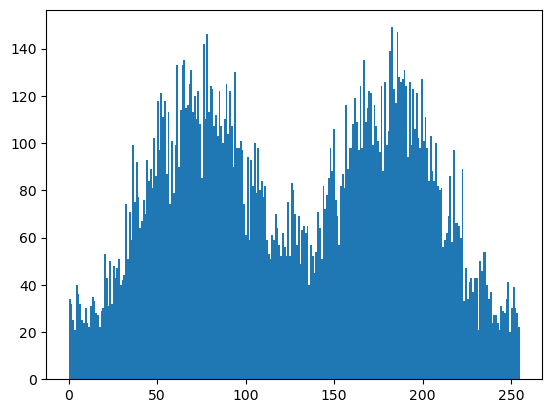

In [90]:
s=time.time()
f_s_t=plt.hist(sample_circ(params_arr[178]),bins=2**qubits)
e=time.time()
print(e-s,'sec')

In [91]:
pg2=f_s_t[0]/(samples)

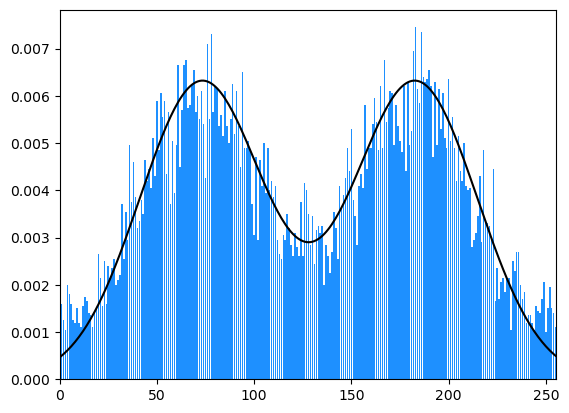

In [92]:
plt.plot(range(2 ** qubits),pg,color='black')
plt.bar(range(2 ** qubits),pg2,color='dodgerblue')
plt.xlim(0,255)
plt.show()

/tmp/ipykernel_293387/1749553359.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.semilogy(x, y, 'k', color='navy',label='$C_{f}$')


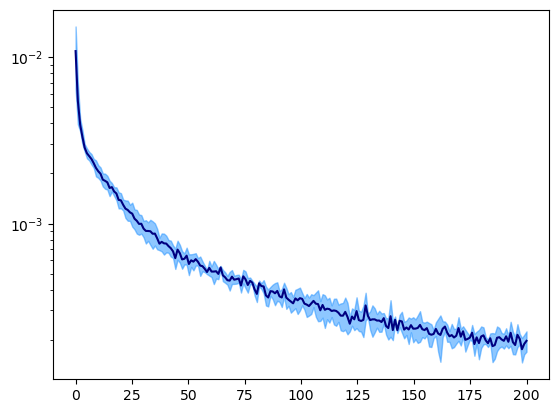

In [142]:
fig, ax = plt.subplots()
x=np.linspace(0,len(ave_cost),len(ave_cost))
y=ave_cost
yerr=std
ax.semilogy(x, y, 'k', color='navy',label='$C_{f}$')
ax.fill_between(x, np.array(y)+np.array(yerr),np.array(y)+(-1)*np.array(yerr),
    alpha=0.5, edgecolor='dodgerblue', facecolor='dodgerblue')
plt.show()

In [272]:

import gc

mmd_grad(params).cpu()
del mmd_grad
gc.collect()
torch.cuda.empty_cache()
